In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torchvision
import torch.nn as nn
import pylops_gpu


from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt,convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from torch.autograd import gradcheck
from pylops_gpu.utils.backend import device
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from calibrate import calibrate

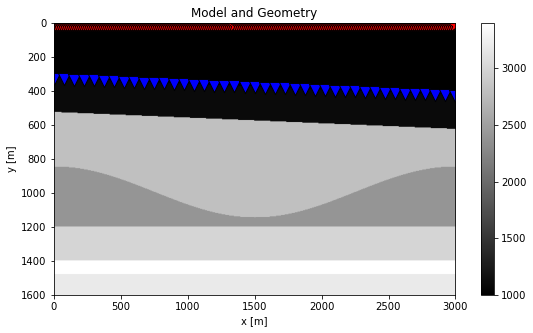

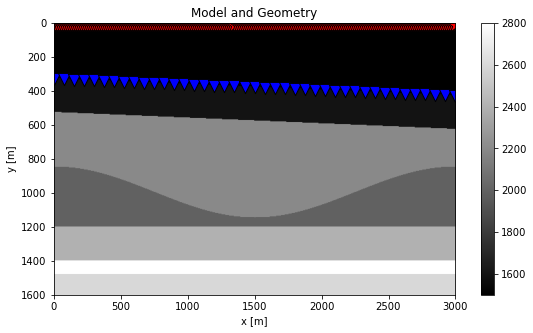

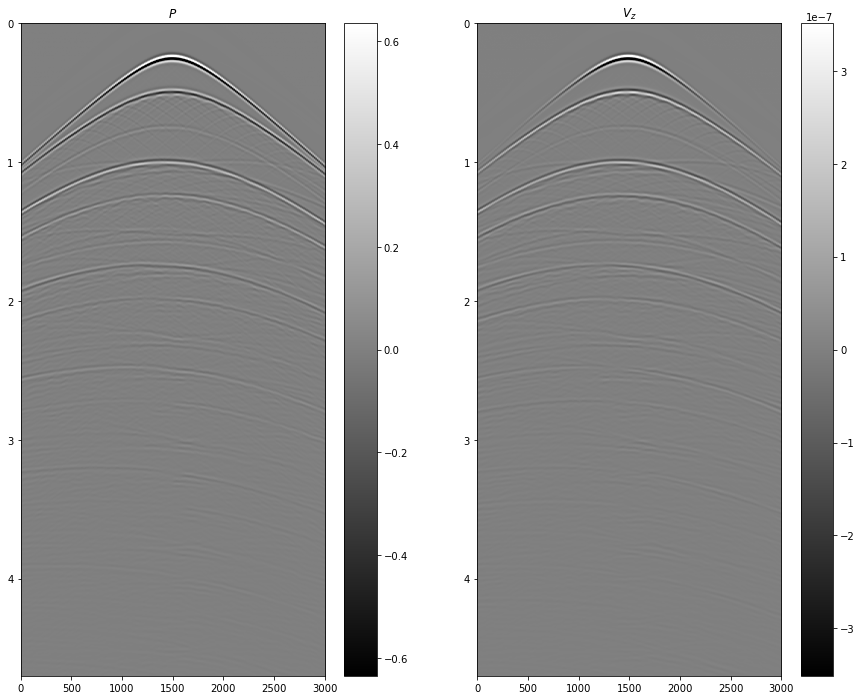

In [2]:

datapath = 'Data' # '' or '/home/ravasim/Documents/Data/fdva_dipping_old/'

inputfile = os.path.join(datapath, 'input_dipping_recsolid.npz')

vel_dir = 1500.0 # velocity of water
vel_sep = 1600.0 # velocity at separation level
rho_sep = 1100.0 # density at separation level

#method = 'sum'
#method = 'rec_ana'
method = 'src_ana'
#method = 'src_inv'

inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
r = r[:, 201:]
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 941, 0.005
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

# Data
p = inputdata['p']
vz = inputdata['vz']
vx = inputdata['vz']


p = np.apply_along_axis(convolve, 1, p, wav, mode='full')
p = p[:, wav_c:][:, :nt]
vz = np.apply_along_axis(convolve, 1, vz, wav, mode='full')
vz = vz[:, wav_c:][:, :nt]
vx = np.apply_along_axis(convolve, 1, vx, wav, mode='full')
vx = vx[:, wav_c:][:, :nt]

# Normalize
vz /= p.max()
vx /= p.max()
p /= p.max()

clip=0.5

plt.figure(figsize=(9,5))
im = plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

fig, axs = plt.subplots(1, 2, figsize=(15,12))
im=axs[0].imshow(p[ns//2], cmap='gray', vmin=-clip*np.abs(p).max(), vmax=clip*np.abs(p).max(),
                 extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$P$')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])
im=axs[1].imshow(vz[ns//2], cmap='gray', vmin=-clip*np.abs(vz).max(), vmax=clip*np.abs(vz).max(),
                 extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$V_z$')
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1]);

In [3]:
method='src_ana'
data = np.load('updown_dipping_belowseabed_%s.npz'% method)
pup = data['pup'] 
pdown = data['pdown'] 

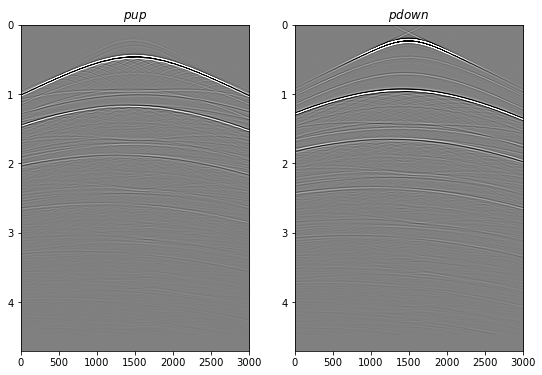

In [4]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50 # 400
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0))).astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0))).astype('float32')
ntpad = pup.shape[1]
tpad = np.arange(ntpad) * dt

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[ns//2], cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-0.1*np.abs(p).max(), vmax=0.1*np.abs(p).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight');

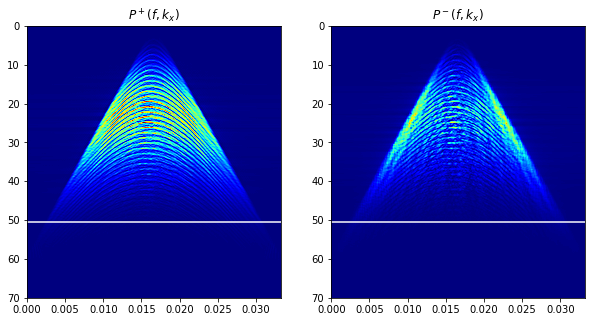

In [5]:
# check max frequency to use
nfmax=250#550
nfft = ntpad#2**11

FFTop = FFT2D(dims=[nr, ntpad], nffts=[nfft, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[ns//2].T.flatten()).reshape(nfft, nfft)


fig, axs = plt.subplots(1, 2, figsize=(10,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
axs[0].set_ylim(70, 0);
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight');
axs[1].set_ylim(70, 0);           

In [6]:
pup = np.swapaxes(pup,2,1)
pdown = np.swapaxes(pdown,2,1)

pdown2 = np.concatenate((np.zeros((ns, nr, ntpad-1)), pdown), axis=-1)

In [7]:
pdown_fft = np.fft.rfft(pdown2, 2*ntpad-1, axis=-1)
pdown_fft = pdown_fft[...,:nfmax]
pdown_fft = pdown_fft.transpose(2,0,1)

MDCop=MDC(pdown_fft, nt=2*ntpad-1, nv=1, dt=dt, dr=dr, 
          twosided=True, transpose=False)
dottest(MDCop, MDCop.shape[0], MDCop.shape[1], complexflag=0, verb=True)

Dot test passed, v^T(Opu)=-15009.834683 - u^T(Op^Tv)=-15009.834683


True

In [8]:
pupd= pup[:,ns//2,:]
print(pupd.shape)
pupd2 = np.concatenate((np.zeros((nr, ntpad-1)), pupd), axis=-1).T
print(pupd2.shape)

madj = MDCop.H * pupd2.ravel()
madj = madj.reshape(2*ntpad-1, nr)

(201, 991)
(1981, 201)


In [9]:
MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
pdown2 = torch.from_numpy(pdown2)
pupd2 = torch.from_numpy(pupd2)

In [10]:
lossdict = {}
avgdict = {}

In [11]:
class GwavSGD(nn.Module):
  def __init__(self,ntpad,nv,dt,dr,ns):
    self.ntpad = ntpad
    self.nv = nv
    self.dt = dt
    self.dr =dr
    self.ns = ns
    super().__init__()


  def forward(self, model, pdown_fft):
    
    MDCop=MDC(pdown_fft, nt=2*self.ntpad-1, nv=self.nv, dt=self.dt, dr=self.dr, 
              twosided=True, transpose=False)
    

    MDCop = pylops_gpu.TorchOperator(MDCop, pylops = True)
   
    data1 = MDCop.apply(model.flatten())
    data1 = data1.view(2*self.ntpad-1, self.ns)

    return data1

In [12]:
def advoptMDD(model, optimizer, lr):
  if optimizer == 'SGD':

      optimizer = torch.optim.SGD([model], lr = lr, momentum =0.99, nesterov=True)
   
  elif optimizer == 'Adadelta':
   
      optimizer = torch.optim.Adadelta([model], lr =lr)
    
  elif optimizer == 'Adam':
   
      optimizer= torch.optim.Adam([model], lr=lr, weight_decay=1e-3, amsgrad=True)
   

  elif optimizer == 'RMSprop':
  
      optimizer= torch.optim.RMSprop([model], lr =lr,weight_decay =0, momentum=0,centered=True, eps = 1e-4)


  elif optimizer == 'Adagrad':
  
      optimizer= torch.optim.Adagrad([model], lr = lr, weight_decay =1e-2)
      
  return optimizer


In [13]:

def advancedSolvers(GwavSGD,model,pupd2,pdown2,ntpad,nv,dt,dr,ns,optimizer,lr,n_epochs):
  criterion = nn.MSELoss()
  optimizer = advoptMDD(model, optimizer, lr)
 

  GwavTorch = GwavSGD(ntpad,nv,dt,dr,ns)
  lossHist=[]
  lossavg=[]
  for epoch in range(n_epochs):
    data1 = GwavTorch(model, pdown_fft)
    lost = criterion(data1,pupd2)
    loss = (1/pdown2.shape[0]) * lost
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    
    
    lossHist.append(loss.item())
   
    avg = sum(lossHist) / len(lossHist)
    lossavg.append(avg)
    
    
    if (epoch+1) %10 ==0:
     print(f'epoch: {epoch+1}, loss : {loss.item():.4f}, loss avg : {avg: }')

 
    lossdict[optimizer] = lossHist
    avgdict[optimizer] = lossavg

  return lossHist, lossavg, data1


In [14]:
model = np.zeros((pdown2.shape[2], pdown2.shape[0]))
model = torch.from_numpy(model)
model.requires_grad= True

modelSGD = model

nv=1
lossHist, lossavg, data1= advancedSolvers(GwavSGD,modelSGD,pupd2,pdown2,ntpad,nv,dt,dr,ns,'SGD', lr =40,n_epochs=200)

epoch: 10, loss : 0.0000, loss avg :  1.5366597041690042e-06
epoch: 20, loss : 0.0000, loss avg :  1.4031618427409601e-06
epoch: 30, loss : 0.0000, loss avg :  1.3457217368481448e-06
epoch: 40, loss : 0.0000, loss avg :  1.3031872432748997e-06
epoch: 50, loss : 0.0000, loss avg :  1.2762193500921928e-06
epoch: 60, loss : 0.0000, loss avg :  1.2548123192067924e-06
epoch: 70, loss : 0.0000, loss avg :  1.23870787024301e-06
epoch: 80, loss : 0.0000, loss avg :  1.225657934384462e-06
epoch: 90, loss : 0.0000, loss avg :  1.2150366753457571e-06
epoch: 100, loss : 0.0000, loss avg :  1.2061756901231231e-06
epoch: 110, loss : 0.0000, loss avg :  1.198663004868402e-06
epoch: 120, loss : 0.0000, loss avg :  1.1922508761381656e-06
epoch: 130, loss : 0.0000, loss avg :  1.1867143739948276e-06
epoch: 140, loss : 0.0000, loss avg :  1.181878939650733e-06
epoch: 150, loss : 0.0000, loss avg :  1.1776133935420009e-06
epoch: 160, loss : 0.0000, loss avg :  1.1738505614561493e-06
epoch: 170, loss : 0.0

In [15]:
model = np.zeros((pdown2.shape[2], pdown2.shape[0]))
model = torch.from_numpy(model)
model.requires_grad= True

modelAdam = model

nv=1
lossHist, lossavg, data1= advancedSolvers(GwavSGD,modelAdam,pupd2,pdown2,ntpad,nv,dt,dr,ns,'Adam', lr =0.001,n_epochs=100)

epoch: 10, loss : 0.0000, loss avg :  7.09946681711021e-05
epoch: 20, loss : 0.0000, loss avg :  4.38657879115398e-05
epoch: 30, loss : 0.0000, loss avg :  3.118086387174375e-05
epoch: 40, loss : 0.0000, loss avg :  2.406035115387451e-05
epoch: 50, loss : 0.0000, loss avg :  1.960315237017871e-05
epoch: 60, loss : 0.0000, loss avg :  1.6581823177655746e-05
epoch: 70, loss : 0.0000, loss avg :  1.4409468471572313e-05
epoch: 80, loss : 0.0000, loss avg :  1.2775975998924226e-05
epoch: 90, loss : 0.0000, loss avg :  1.1504173198634236e-05
epoch: 100, loss : 0.0000, loss avg :  1.0486340021537435e-05


In [16]:
model = np.zeros((pdown2.shape[2], pdown2.shape[0]))
model = torch.from_numpy(model)
model.requires_grad= True

modelAdadelta = model

nv=1
lossHist, lossavg, data1= advancedSolvers(GwavSGD,modelAdadelta,pupd2,pdown2,ntpad,nv,dt,dr,ns,'Adadelta', lr =50,n_epochs=200)

epoch: 10, loss : 0.0000, loss avg :  1.667111584280102e-06
epoch: 20, loss : 0.0000, loss avg :  1.4842585109655297e-06
epoch: 30, loss : 0.0000, loss avg :  1.3969772857599988e-06
epoch: 40, loss : 0.0000, loss avg :  1.3438279126726888e-06
epoch: 50, loss : 0.0000, loss avg :  1.3076083538300551e-06
epoch: 60, loss : 0.0000, loss avg :  1.2812448395057467e-06
epoch: 70, loss : 0.0000, loss avg :  1.2611848938916991e-06
epoch: 80, loss : 0.0000, loss avg :  1.2454160257291441e-06
epoch: 90, loss : 0.0000, loss avg :  1.2327028264357889e-06
epoch: 100, loss : 0.0000, loss avg :  1.2222419894367934e-06
epoch: 110, loss : 0.0000, loss avg :  1.2134878972495752e-06
epoch: 120, loss : 0.0000, loss avg :  1.2060569512673543e-06
epoch: 130, loss : 0.0000, loss avg :  1.1996717388086936e-06
epoch: 140, loss : 0.0000, loss avg :  1.1941268242830626e-06
epoch: 150, loss : 0.0000, loss avg :  1.1892669492954418e-06
epoch: 160, loss : 0.0000, loss avg :  1.1849726810883612e-06
epoch: 170, loss :

In [17]:
model = np.zeros((pdown2.shape[2], pdown2.shape[0]))
model = torch.from_numpy(model)
model.requires_grad= True

modelAdagrad = model

nv=1
lossHist, lossavg, data1= advancedSolvers(GwavSGD,modelAdagrad,pupd2,pdown2,ntpad,nv,dt,dr,ns,'Adagrad', lr =0.1,n_epochs=100)

epoch: 10, loss : 0.0000, loss avg :  0.4215917908932637
epoch: 20, loss : 0.0000, loss avg :  0.21079808012850912
epoch: 30, loss : 0.0000, loss avg :  0.14053284933547674
epoch: 40, loss : 0.0000, loss avg :  0.10540013513098481
epoch: 50, loss : 0.0000, loss avg :  0.08432049268152893
epoch: 60, loss : 0.0000, loss avg :  0.07026739458892596
epoch: 70, loss : 0.0000, loss avg :  0.060229466435448804
epoch: 80, loss : 0.0000, loss avg :  0.05270101998421879
epoch: 90, loss : 0.0000, loss avg :  0.04684556150603027
epoch: 100, loss : 0.0000, loss avg :  0.04216119467224809


In [18]:
model = np.zeros((pdown2.shape[2], pdown2.shape[0]))
model = torch.from_numpy(model)
model.requires_grad= True

modelRMSprop = model

nv=1
lossHist, lossavg, data1= advancedSolvers(GwavSGD,modelRMSprop,pupd2,pdown2,ntpad,nv,dt,dr,ns,'RMSprop', lr =0.01,n_epochs=200)

epoch: 10, loss : 0.0000, loss avg :  1.5031573232569936e-06
epoch: 20, loss : 0.0000, loss avg :  1.353484812650038e-06
epoch: 30, loss : 0.0000, loss avg :  1.2876917326941444e-06
epoch: 40, loss : 0.0000, loss avg :  1.2502453870208018e-06
epoch: 50, loss : 0.0000, loss avg :  1.2261019594848364e-06
epoch: 60, loss : 0.0000, loss avg :  1.2092722782693747e-06
epoch: 70, loss : 0.0000, loss avg :  1.1968825839373184e-06
epoch: 80, loss : 0.0000, loss avg :  1.187384168862264e-06
epoch: 90, loss : 0.0000, loss avg :  1.1798709565655078e-06
epoch: 100, loss : 0.0000, loss avg :  1.1737786890706618e-06
epoch: 110, loss : 0.0000, loss avg :  1.1687381374104756e-06
epoch: 120, loss : 0.0000, loss avg :  1.1644977441469211e-06
epoch: 130, loss : 0.0000, loss avg :  1.1608802809053796e-06
epoch: 140, loss : 0.0000, loss avg :  1.1577573080947143e-06
epoch: 150, loss : 0.0000, loss avg :  1.1550334723977961e-06
epoch: 160, loss : 0.0000, loss avg :  1.1526364960437681e-06
epoch: 170, loss : 

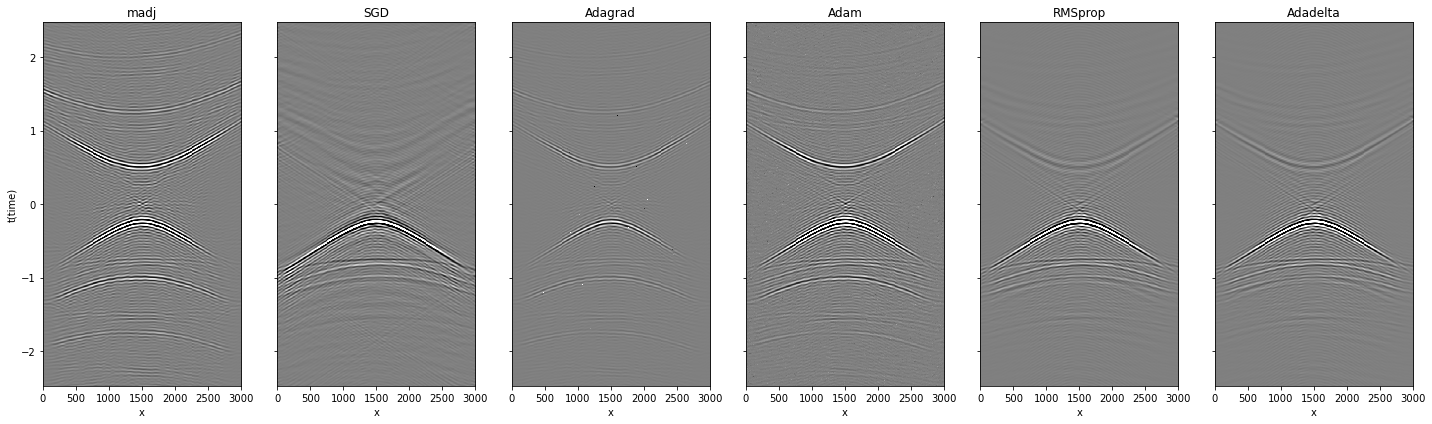

In [23]:
fig, axs = plt.subplots(1,6, sharey=True,figsize=(20,6))
axs[0].imshow(madj, aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-0.3*np.abs(madj).max(), vmax=0.3*np.abs(madj).max(),
              extent = (r[0, 0], r[0,-1], -tpad[-1], tpad[-1]))
axs[0].set_title('madj', fontsize=12)
axs[0].set_xlabel('x'),axs[0].set_ylabel('t')

axs[1].imshow(modelSGD.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-0.2*np.abs(modelSGD.detach().numpy()).max(), vmax=0.2*np.abs(modelSGD.detach().numpy()).max(),
              extent = (r[0, 0], r[0,-1], -tpad[-1], tpad[-1]))
axs[1].set_title('SGD', fontsize=12)
axs[1].set_ylim(-tpad[ntpad//2], tpad[ntpad//2])
axs[1].set_xlabel('x'),axs[0].set_ylabel('t')


axs[2].imshow(modelAdagrad.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-0.2*np.abs(modelAdagrad.detach().numpy()).max(), vmax=0.2*np.abs(modelAdagrad.detach().numpy()).max(),
              extent = (r[0, 0], r[0,-1], -tpad[-1], tpad[-1]))
axs[2].set_title('Adagrad', fontsize=12)
axs[2].set_xlabel('x'),axs[0].set_ylabel('t')


axs[3].imshow(modelAdam.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-0.2*np.abs(modelAdam.detach().numpy()).max(), vmax=0.2*np.abs(modelAdam.detach().numpy()).max(),
              extent = (r[0, 0], r[0,-1], -tpad[-1], tpad[-1]))
axs[3].set_title('Adam', fontsize=12)
axs[3].set_xlabel('x'),axs[0].set_ylabel('t')


axs[4].imshow(modelRMSprop.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-0.2*np.abs(modelRMSprop.detach().numpy()).max(), vmax=0.2*np.abs(modelRMSprop.detach().numpy()).max(),
              extent = (r[0, 0], r[0,-1], -tpad[-1], tpad[-1]))
axs[4].set_title('RMSprop', fontsize=12)
axs[4].set_xlabel('x'),axs[0].set_ylabel('t')


axs[5].imshow(modelAdadelta.detach().numpy(), aspect='auto', interpolation='nearest', cmap='gray',
              vmin=-0.2*np.abs(modelAdadelta.detach().numpy()).max(), vmax=0.2*np.abs(modelAdadelta.detach().numpy()).max(),
              extent = (r[0, 0], r[0,-1], -tpad[-1], tpad[-1]))
axs[5].set_title('Adadelta', fontsize=12)
axs[5].set_xlabel('x'),axs[0].set_ylabel('t(time)')


plt.tight_layout(w_pad =2)

